# 1. 이미지 분류를 위한 신경망

## 1) LeNet-5

In [1]:
# 라이브러리 호출
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms # 이미지 변환(전처리) 기능 제공
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm # 진행 상황을 가시적으로 표현, 모델의 학습 경과를 확인
import random
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 파이토치는 텐서플로우와 다르게 GPU를 자동으로 할당해주지 않음
# GPU할당을 모델과 데이터에 선언해주어야함

In [2]:
# 이미지 데이터셋 전처리
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train' : transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [3]:
# 이미지 데이터셋을 불러온 후, 훈련/검증/테스트 데이터셋으로 분리
cat_directory = r'./data/dogs-vs-cats/Cat'
dog_directory = r'./data/dogs-vs-cats/Dog'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400] # 훈련용 400개 이미지
val_images_filepaths = correct_images_filepaths[400:-10] # 검증용 92개 이미지
test_images_filepaths = correct_images_filepaths[-10:] # 테스트용 10개 이미지
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [4]:
os.listdir(cat_directory)

['cat.0.jpg',
 'cat.1.jpg',
 'cat.10.jpg',
 'cat.100.jpg',
 'cat.101.jpg',
 'cat.102.jpg',
 'cat.103.jpg',
 'cat.104.jpg',
 'cat.105.jpg',
 'cat.106.jpg',
 'cat.107.jpg',
 'cat.108.jpg',
 'cat.109.jpg',
 'cat.11.jpg',
 'cat.110.jpg',
 'cat.111.jpg',
 'cat.112.jpg',
 'cat.113.jpg',
 'cat.114.jpg',
 'cat.115.jpg',
 'cat.116.jpg',
 'cat.117.jpg',
 'cat.118.jpg',
 'cat.119.jpg',
 'cat.12.jpg',
 'cat.120.jpg',
 'cat.121.jpg',
 'cat.122.jpg',
 'cat.123.jpg',
 'cat.124.jpg',
 'cat.125.jpg',
 'cat.126.jpg',
 'cat.127.jpg',
 'cat.128.jpg',
 'cat.129.jpg',
 'cat.13.jpg',
 'cat.130.jpg',
 'cat.131.jpg',
 'cat.132.jpg',
 'cat.133.jpg',
 'cat.134.jpg',
 'cat.135.jpg',
 'cat.136.jpg',
 'cat.137.jpg',
 'cat.138.jpg',
 'cat.139.jpg',
 'cat.14.jpg',
 'cat.140.jpg',
 'cat.141.jpg',
 'cat.142.jpg',
 'cat.143.jpg',
 'cat.144.jpg',
 'cat.145.jpg',
 'cat.146.jpg',
 'cat.147.jpg',
 'cat.148.jpg',
 'cat.149.jpg',
 'cat.15.jpg',
 'cat.150.jpg',
 'cat.151.jpg',
 'cat.152.jpg',
 'cat.153.jpg',
 'cat.154.jpg',
 '

In [5]:
os.listdir(dog_directory)

['dog.0.jpg',
 'dog.1.jpg',
 'dog.10.jpg',
 'dog.100.jpg',
 'dog.101.jpg',
 'dog.102.jpg',
 'dog.103.jpg',
 'dog.104.jpg',
 'dog.105.jpg',
 'dog.106.jpg',
 'dog.107.jpg',
 'dog.108.jpg',
 'dog.109.jpg',
 'dog.11.jpg',
 'dog.110.jpg',
 'dog.111.jpg',
 'dog.112.jpg',
 'dog.113.jpg',
 'dog.114.jpg',
 'dog.115.jpg',
 'dog.116.jpg',
 'dog.117.jpg',
 'dog.118.jpg',
 'dog.119.jpg',
 'dog.12.jpg',
 'dog.120.jpg',
 'dog.121.jpg',
 'dog.122.jpg',
 'dog.123.jpg',
 'dog.124.jpg',
 'dog.125.jpg',
 'dog.126.jpg',
 'dog.127.jpg',
 'dog.128.jpg',
 'dog.129.jpg',
 'dog.13.jpg',
 'dog.130.jpg',
 'dog.131.jpg',
 'dog.132.jpg',
 'dog.133.jpg',
 'dog.134.jpg',
 'dog.135.jpg',
 'dog.136.jpg',
 'dog.137.jpg',
 'dog.138.jpg',
 'dog.139.jpg',
 'dog.14.jpg',
 'dog.140.jpg',
 'dog.141.jpg',
 'dog.142.jpg',
 'dog.143.jpg',
 'dog.144.jpg',
 'dog.145.jpg',
 'dog.146.jpg',
 'dog.147.jpg',
 'dog.148.jpg',
 'dog.149.jpg',
 'dog.15.jpg',
 'dog.150.jpg',
 'dog.151.jpg',
 'dog.152.jpg',
 'dog.153.jpg',
 'dog.154.jpg',
 '

In [6]:
import os
list_path = ['C:\\', 'Temp', 'user']
folder_path = os.path.join(*list_path)
folder_path

'C:\\Temp\\user'

In [7]:
# random.seed() 예시
import numpy as np

np.random.seed(101)
np.random.randint(low=1, high=10, size=10)

array([2, 7, 8, 9, 5, 9, 6, 1, 6, 9])

In [8]:
np.random.seed(100)
np.random.randint(low=1, high=10, size=10)

array([9, 9, 4, 8, 8, 1, 5, 3, 6, 3])

In [9]:
np.random.seed(101)
np.random.randint(low=1, high=10, size=10)

array([2, 7, 8, 9, 5, 9, 6, 1, 6, 9])

In [10]:
# 테스트 데이터셋 이미지 확인
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12,6))
    
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label==predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
        
    plt.tight_layout()
    plt.show()

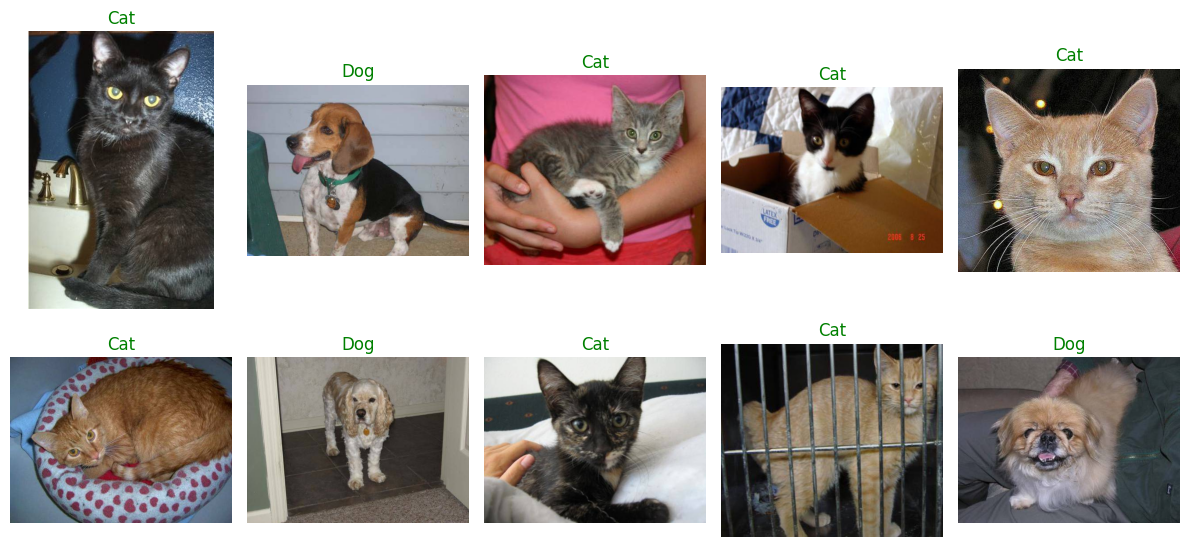

In [11]:
# 테스트 데이터셋 이미지 출력
display_image_grid(test_images_filepaths)

In [12]:
# 이미지 데이터셋 클래스 정의
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'): # 데이터셋의 전처리
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx) -> torch.Tensor: # 데이터셋에서 데이터를 가져오는 부분
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        label = img_path.split(os.sep)[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [13]:
# 변수 값 정의
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [14]:
# 이미지 데이터셋 정의 (train, val)
train_dataset = DogvsCatDataset(train_images_filepaths,
                                transform=ImageTransform(size, mean, std), phase='train')

val_dataset = DogvsCatDataset(val_images_filepaths,
                              transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size()) # train_dataset.__getitem__[0][0]의 크기 출력
print(train_dataset.__getitem__(index)[1]) # 훈련 데이터의 label 출력

torch.Size([3, 224, 224])
0


In [15]:
train_dataset

In [16]:
train_dataset.__getitem__(index)

(tensor([[[-1.5357, -1.4672, -1.5528,  ..., -0.3369, -0.3027, -0.3712],
          [-1.5699, -1.4843, -1.5357,  ..., -0.3369, -0.3198, -0.3198],
          [-1.6727, -1.6213, -1.5699,  ..., -0.2684, -0.2856, -0.2856],
          ...,
          [-1.6555, -1.7240, -1.6555,  ..., -0.7308, -0.9020, -0.9877],
          [-1.7069, -1.8439, -1.8439,  ..., -0.7479, -0.8849, -1.0048],
          [-1.6555, -1.7412, -1.8097,  ..., -0.8678, -0.8678, -0.9192]],
 
         [[-1.5105, -1.3880, -1.4755,  ..., -0.3375, -0.2850, -0.3550],
          [-1.5630, -1.4405, -1.4930,  ..., -0.2850, -0.2675, -0.2850],
          [-1.6856, -1.5980, -1.5455,  ..., -0.2150, -0.2325, -0.2325],
          ...,
          [-1.6681, -1.7381, -1.6681,  ..., -1.2129, -1.3880, -1.4755],
          [-1.7206, -1.8606, -1.8606,  ..., -1.1604, -1.3004, -1.4230],
          [-1.6681, -1.7556, -1.8256,  ..., -1.2654, -1.2479, -1.3004]],
 
         [[-1.3164, -1.2467, -1.3339,  ..., -0.2010, -0.1487, -0.2184],
          [-1.3687, -1.2990,

In [17]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 0])


In [18]:
# 모델의 네트워크 클래스
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(32*53*53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)
        
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
#         print(out.size())
#         print('-----------')
#         print(out.size(0))
        out = out.view(out.size(0), -1) # 데이터 형태를 1차원으로 변경
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

In [19]:
# 모델 객체 생성
model = LeNet()
model

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)

In [20]:
# torchsummary 라이브러리를 이용한 모델의 네트워크 구조 확인
from torchsummary import summary
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

C:\Users\AIFFEL\miniconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [21]:
# 학습 가능한 파라미터 수 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [22]:
# 옵티마이저와 손실 함수 정의
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [23]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [24]:
criterion

CrossEntropyLoss()

In [25]:
# 모델의 파라미터와 손실 함수를 CPU에 할당
model = model.to(device)
criterion = criterion.to(device)

In [26]:
model

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)

In [27]:
criterion

CrossEntropyLoss()

In [28]:
# 모델 학습 함수 정의
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print("Epoch {}/{}".format(epoch+1, num_epoch))
        print("-"*20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]): # dataloader_dict: 훈련 데이터셋(train_loader)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() # 역전파 단계를 실행하기 전, 기울기를 0으로 초기화
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels) # 오차 계산
                    
                    if phase == 'train':
                        loss.backward() # 모델의 학습 가능한 모든 파라미터에 대해 기울기 계산
                        optimizer.step() # 파라미터 갱신
                    
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset) # 최종 오차 계산 // 오차를 데이터셋 개수로 나눔
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset) # 최종 정확도를 데이터셋 개수로 나눔
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc: # 검증 데이터셋에 대한 가장 최적의 정확도를 저장
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:.4f}".format(best_acc))
    return model

In [29]:
# 모델 학습
import time

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


C:\Users\AIFFEL\AppData\Local\Temp\ipykernel_26660\3726486612.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]): # dataloader_dict: 훈련 데이터셋(train_loader)


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6962 Acc: 0.5075


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6959 Acc: 0.5109
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6849 Acc: 0.5400


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7092 Acc: 0.4022
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6777 Acc: 0.5325


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7117 Acc: 0.5326
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6756 Acc: 0.5575


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7279 Acc: 0.4457
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6760 Acc: 0.5725


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7134 Acc: 0.4891
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6702 Acc: 0.5900


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7125 Acc: 0.5000
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6649 Acc: 0.6125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7122 Acc: 0.5000
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6606 Acc: 0.6100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7201 Acc: 0.4783
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6536 Acc: 0.6450


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7098 Acc: 0.5000
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6543 Acc: 0.6175


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7386 Acc: 0.4674
Training complete in 3m 34s
Best val Acc: 0.5326


In [32]:
# 모델 테스트를 위한 함수 정의
import pandas as pd

id_list = []
pred_list = []
_id = 0

with torch.no_grad(): # 역전파 중 텐서들에 대한 변화도를 계산할 필요가 없음 // train과 가장 다른 점
    for test_path in tqdm(test_images_filepaths): # 테스트 데이터셋 이용
        img = Image.open(test_path)
        _id = test_path.split(os.sep)[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)
        
        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])
        res = pd.DataFrame({
            'id': id_list,
            'label': pred_list
        })
        
res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('./data/LeNet.csv', index=False)

C:\Users\AIFFEL\AppData\Local\Temp\ipykernel_26660\1615581532.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths): # 테스트 데이터셋 이용


  0%|          | 0/10 [00:00<?, ?it/s]

In [33]:
# 테스트 데이터셋의 예측 결과 호출
res.head(10)

,id,label
0,109,0.346527
1,145,0.294339
2,15,0.446119
3,162,0.395109
4,167,0.446896
5,200,0.327984
6,210,0.536000
7,211,0.394404
8,213,0.370979
9,224,0.477441


In [36]:
# 테스트 데이터셋 이미지를 출력하기 위한 함수 정의
class_ = classes = {0: 'cat', 1: 'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12,6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        a = random.choice(res['id'].values) # 데이터프레임의 id라는 컬럼에서, 임의로 데이터 가지고옴
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5: # 강아지
            label = 1
        else: # 고양이
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
        
    plt.tight_layout()
    plt.show()

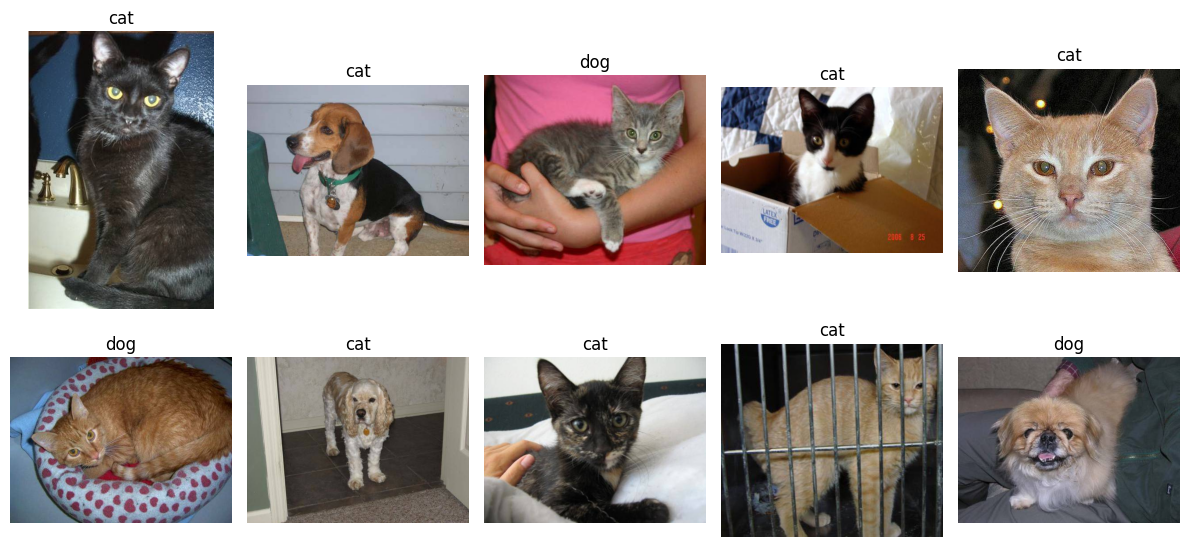

In [37]:
# 테스트 데이터셋 예측 결과 이미지 출력
display_image_grid(test_images_filepaths)